<a href="https://colab.research.google.com/github/n1c0e/Data_Mining-IIC2433-PUC/blob/main/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Entrega 3 </h2>
    <p>
        Profesor Marcelo Mendoza<br>
        Segundo Semestre 2022<br>    
    </p>
    <br>
</center>
<br>

Autores: <br>
Nicolás Espina <br>
Gabriel Catalán <br>
Sofía Rebolledo <br>
Jonathan Riquelme <br>



---

## Setup


In [29]:
from IPython.display import clear_output

!pip3 uninstall spacy
!pip3 install spacy

!spacy download en_core_web_lg
clear_output()
print('Ahora debes reiniciar el entorno de ejecución y ejecutar a partir de la siguiente celda')

Ahora debes reiniciar el entorno de ejecución y ejecutar a partir de la siguiente celda


In [30]:
# Librerías
import pandas as pd
import numpy as np
from collections import defaultdict
import spacy

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier as DTC
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sb

In [31]:
nlp = spacy.load("en_core_web_lg")

## Importar dataset

In [5]:
data_train_url = "/train.dat"
data_test_url = "/test.dat"

DATA_TRAIN = pd.read_csv(data_train_url, sep='	', header=None, names=['label', 'abstract'])
DATA_TEST = pd.read_csv(data_test_url, sep='	', header=None, names=['abstract'])
DATA_TRAIN.head()

,label,abstract
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...


In [6]:
DATA_TEST.head()

,abstract
0,Excision of limbal dermoids. We reviewed the c...
1,Bell's palsy. A diagnosis of exclusion. In cas...
2,Retained endobronchial foreign body removal fa...
3,Recurrent buccal space abscesses: a complicati...
4,Intracranial fibromatosis. Fibromatoses are un...


## Preprocesamiento de datos

In [7]:
# Funciones dadas la tarea 2
import string

all_stopwords = nlp.Defaults.stop_words

def remove_punctuation(text):
  text = [token for token in text if not token.is_punct]
  return text

def remove_stopwords(words):
  words = [word for word in words if not word in all_stopwords]
  return words

def lemmatize(words):
  words = [word.lemma_ for word in words]
  return words

def remove_non_alpha(words):
  words = [word for word in words if word.isalpha()]
  return words

def lower(words):
  words = [word.lower() for word in words]
  return words

def preprocess(text):

  doc = nlp(text)
  tokens = remove_punctuation(doc)
  tokens = remove_stopwords(tokens)
  tokens = lemmatize(tokens)
  tokens = remove_non_alpha(tokens)
  tokens = lower(tokens)

  return ' '.join(tokens).strip()


def sentence_vector(text):
  text = nlp(text)
  vectores = []
  for t in text:
    t_vector = t.vector
    vectores.append(t_vector)
  return np.array(vectores).sum(axis=0)/len(vectores)

Vectorizar train data

In [8]:
# df_train = DATA_TRAIN.copy().drop(df_train.index[500:])
df_train = DATA_TRAIN.copy().sample(n=750)
df_train

,label,abstract
5268,5,Spontaneous rupture of a normal bladder. We ha...
8913,2,Detection of active intraabdominal arterial he...
7548,5,Vaginal bleeding in childhood and adolescence....
7278,3,Fulminant hepatitis after lisinopril administr...
9992,2,Outpatient health care utilization of patients...
...,...,...
5605,1,Ampullary tumor caused by metastatic renal cel...
7912,4,"Change in sympathetic activity before, during,..."
13664,3,Clinical judgments in pain management. From re...
5831,1,Technetium-99m(v) dimercaptosuccinic acid plan...


In [9]:
df_train['abstract'] = df_train['abstract'].apply(preprocess)
df_train.head()

,label,abstract
5268,5,spontaneous rupture of a normal bladder we hav...
8913,2,detection of active intraabdominal arterial he...
7548,5,vaginal bleeding in childhood and adolescence ...
7278,3,fulminant hepatitis after lisinopril administr...
9992,2,outpatient health care utilization of patient ...


In [10]:
df_train['abstract'] = df_train['abstract'].apply(sentence_vector)

Vectorizar test data

In [ ]:
# df_test = DATA_TEST.copy().drop(df_test.index[50:])
# df_test['abstract'] = df_test['abstract'].apply(preprocess)
# df_test['abstract'] = df_test['abstract'].apply(sentence_vector)
# df_test.head()

### Dividir DATA en sets de train y de test aplicar PCA

Como solo data_train viene con labels, dividiremos este dataset en sets de train y de test con la función `train_test_split` de sklearn.model_selection.



In [17]:
# Realiza aquí la separación balanceada en train y test
X = df_train['abstract']
y = df_train['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [12]:
X_train.shape

(562,)

In [21]:
X_train = [i.tolist() for i in X_train.to_numpy()]
X_test = [i.tolist() for i in X_test.to_numpy()]

In [25]:
print(len(X_train))
print(len(X_train[0]))
print(X_train[0])

562
300
[-2.3413994312286377, 0.8796724081039429, -2.2623350620269775, 0.7361485362052917, 4.275763988494873, -0.06303739547729492, 0.5671176910400391, 4.308311462402344, -0.32585522532463074, -0.4600571393966675, 6.198325157165527, 1.36649751663208, -3.5023722648620605, 1.7251909971237183, 0.5927518606185913, 1.626184105873108, 1.2308510541915894, -0.5302327871322632, -2.264859914779663, -1.9821569919586182, 0.5182533860206604, -0.07896526157855988, -2.2009878158569336, 0.2723376452922821, -0.2964448630809784, -2.085529088973999, -2.521280527114868, -0.2781308591365814, -1.2437219619750977, 2.3845443725585938, 1.7617648839950562, 0.3011791408061981, -1.2995154857635498, -1.310420036315918, -1.9497414827346802, -1.8394651412963867, -0.08243899792432785, 1.8528952598571777, 1.726766586303711, 1.0977739095687866, -0.23010562360286713, -0.041012682020664215, 0.22355861961841583, 1.2733945846557617, -1.8432635068893433, 1.9859404563903809, 2.196747064590454, -1.7465753555297852, -0.6232430

In [18]:
y_train = y_train.to_numpy().tolist()


In [19]:
print(len(y_train))

562


Ahora, se aplicará PCA para reducir la dimensionalidad de los vectores retornados por NLP. Estos datos con dimensión menor constituirán una nueva data que se contrastará en la clasificaciones con la data original.







In [28]:
pca_train = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca_train.fit_transform(X_train)
n_filas, n_columnas = X_train_pca.shape
print(X_train_pca.shape)

pca_test = PCA(n_components=n_columnas, svd_solver='full')
X_test_pca = pca_test.fit_transform(X_test)
print(X_test_pca.shape)
print(len(X_train_pca[0]), len(X_test_pca[0]))

(562, 88)
(188, 88)
88 88


## Clasificador

Linear SVC

In [ ]:
param_grid_linearSVC = {'C': [0.1, 1.0, 3.0, 100.0],\
              'loss': ['hinge', 'squared_hinge'],\
              'penalty': ['l1', 'l2']
              }

grid_linearSVC = GridSearchCV(LinearSVC(), param_grid_linearSVC, refit=True)
grid_linearSVC.fit(X_train, y_train)
clear_output()

In [ ]:
linearSVC = LinearSVC().set_params(**grid_linearSVC.best_params_)
linearSVC.fit(X_train, y_train)
y_predict_linearSVC = linearSVC.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print('hiperparámetros LinearSVC:', grid_linearSVC.best_params_)

hiperparámetros LinearSVC: {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}


Matriz de confusión Linear SVC


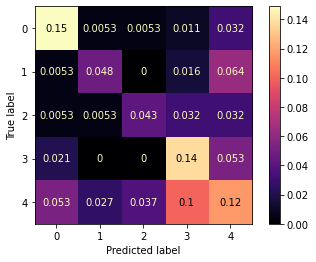

In [ ]:
print("Matriz de confusión Linear SVC")
cm_linearSVC = confusion_matrix(y_test, y_predict_linearSVC, normalize="all")
cm_display = ConfusionMatrixDisplay(cm_linearSVC).plot(cmap='magma')

In [ ]:
print(f"Accuracy LinearSVC = {metrics.accuracy_score(y_test, y_predict_linearSVC) * 100} %")

Accuracy LinearSVC = 49.46808510638298 %


Linear SVC (PCA)

In [ ]:
param_grid_linearSVC = {'C': [0.1, 1.0, 3.0, 100.0],\
              'loss': ['hinge', 'squared_hinge'],\
              'penalty': ['l1', 'l2']
              }

grid_linearSVC = GridSearchCV(LinearSVC(), param_grid_linearSVC, refit=True)
grid_linearSVC.fit(X_train_pca, y_train)
clear_output()

In [ ]:
linearSVC = LinearSVC().set_params(**grid_linearSVC.best_params_)
linearSVC.fit(X_train_pca, y_train)
y_predict_linearSVC = linearSVC.predict(X_test_pca)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print('hiperparámetros LinearSVC:', grid_linearSVC.best_params_)

hiperparámetros LinearSVC: {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}


Matriz de confusión Linear SVC


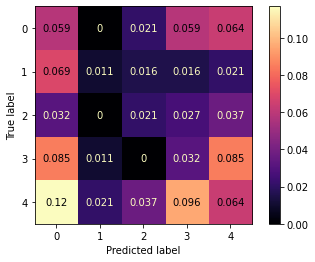

In [ ]:
print("Matriz de confusión Linear SVC")
cm_linearSVC = confusion_matrix(y_test, y_predict_linearSVC, normalize="all")
cm_display = ConfusionMatrixDisplay(cm_linearSVC).plot(cmap='magma')

In [ ]:
print(f"Accuracy LinearSVC = {metrics.accuracy_score(y_test, y_predict_linearSVC) * 100} %")

Accuracy LinearSVC = 18.617021276595743 %


SVC


In [ ]:
param_grid_svc = {'C': [0.1,1, 10, 100],\
                  'gamma': [1,0.1,0.01,0.001],\
                  'kernel': ['rbf', 'poly', 'sigmoid']\
                  }

grid_svc = GridSearchCV(SVC(), param_grid_svc, refit=True)
grid_svc.fit(X_train, y_train)
clear_output()

In [ ]:
svc = SVC().set_params(**grid_svc.best_params_)
svc.fit(X_train, y_train)
y_predict_SVC = svc.predict(X_test)

In [ ]:
print('hiperparámetros SVC:', grid_svc.best_params_)

hiperparámetros SVC: {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}


Matriz de confusión SVC


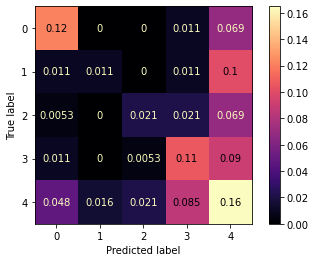

In [ ]:
print("Matriz de confusión SVC")
cm_SVC = confusion_matrix(y_test, y_predict_SVC, normalize="all")
cm_display = ConfusionMatrixDisplay(cm_SVC).plot(cmap='magma')

In [ ]:
print(f"Accuracy SVC = {metrics.accuracy_score(y_test, y_predict_SVC) * 100} %")

Accuracy SVC = 42.5531914893617 %


SVC (PCA)

In [ ]:
param_grid_svc = {'C': [0.1,1, 10, 100],\
                  'gamma': [1,0.1,0.01,0.001],\
                  'kernel': ['rbf', 'poly', 'sigmoid']\
                  }

grid_svc = GridSearchCV(SVC(), param_grid_svc, refit=True)
grid_svc.fit(X_train_pca, y_train)
clear_output()

In [ ]:
svc = SVC().set_params(**grid_svc.best_params_)
svc.fit(X_train_pca, y_train)
y_predict_SVC = svc.predict(X_test_pca)

In [ ]:
print('hiperparámetros SVC:', grid_svc.best_params_)

hiperparámetros SVC: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


Matriz de confusión SVC


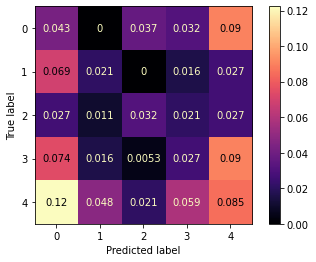

In [ ]:
print("Matriz de confusión SVC")
cm_SVC = confusion_matrix(y_test, y_predict_SVC, normalize="all")
cm_display = ConfusionMatrixDisplay(cm_SVC).plot(cmap='magma')

In [ ]:
print(f"Accuracy SVC = {metrics.accuracy_score(y_test, y_predict_SVC) * 100} %")

Accuracy SVC = 20.74468085106383 %


**PCA disminuye el accuracy. Mejor no utilizar.**

Random Forest

In [ ]:
param_grid_rfc = {'n_estimators': [10, 100, 500, 1000],\
                  'criterion': ['gini', 'entropy', 'log_loss']
                  }

grid_rfc = GridSearchCV(RFC(), param_grid_rfc, refit=True)
grid_rfc.fit(X_train, y_train)
clear_output()

In [ ]:
rfc = RFC().set_params(**grid_rfc.best_params_)
rfc.fit(X_train, y_train)
y_predict_rfc = rfc.predict(X_test)

In [ ]:
print('hiperparámetros RFC:', grid_rfc.best_params_)

hiperparámetros RFC: {'criterion': 'entropy', 'n_estimators': 500}


Matriz de confusión RFC


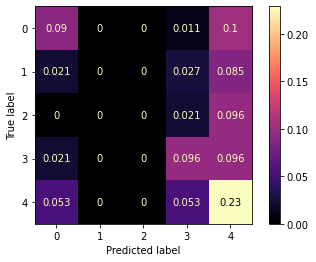

In [ ]:
print("Matriz de confusión RFC")
cm_RFC = confusion_matrix(y_test, y_predict_rfc, normalize="all")
cm_display = ConfusionMatrixDisplay(cm_RFC).plot(cmap='magma')

In [ ]:
print(f"Accuracy RFC = {metrics.accuracy_score(y_test, y_predict_rfc) * 100} %")

Accuracy RFC = 41.48936170212766 %


MLP

In [ ]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 100, 200, 200, 100, 50)],
    'activation': ['logistic', 'relu'],
    'max_iter': [100, 300, 500, 800],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling']
}

grid_MLP = GridSearchCV(MLPClassifier(), param_grid_mlp, refit=True)
grid_MLP.fit(X_train, y_train)
clear_output()

In [ ]:
mlp = MLPClassifier().set_params(**grid_MLP.best_params_)
mlp.fit(X_train, y_train)
y_predict_MLP = mlp.predict(X_test)

In [ ]:
print('hiperparámetros MLP:', grid_MLP.best_params_)

hiperparámetros MLP: {'activation': 'relu', 'hidden_layer_sizes': (50, 100, 200, 200, 100, 50), 'learning_rate': 'constant', 'max_iter': 800, 'solver': 'sgd'}


Matriz de confusión MLP


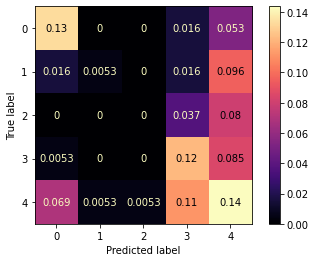

In [ ]:
print("Matriz de confusión MLP")
cm_MLP = confusion_matrix(y_test, y_predict_MLP, normalize="all")
cm_display = ConfusionMatrixDisplay(cm_MLP).plot(cmap='magma')

In [ ]:
print(f"Accuracy MLP = {metrics.accuracy_score(y_test, y_predict_MLP) * 100} %")

Accuracy MLP = 40.42553191489361 %


ADABoost

In [ ]:
param_grid_ada = {
    'estimator': [DTC(max_depth=2), DTC(max_depth=10), DTC(max_depth=100)],
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0, 10, 50, 100, 1000],
    'algorithm': ['SAMME', 'SAMME.R'],
}

grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid_ada, refit=True)
grid_ada.fit(X_train, y_train)
clear_output()

ValueError: ignored

In [ ]:
abc = AdaBoostClassifier().set_params(**grid_ada.best_params_)
abc.fit(X_train, y_train)
y_predict_abc = abc.predict(X_test)

In [ ]:
_print("Matriz de confusión ABC")
cm_abc = confusion_matrix(y_test, y_predict_abc, normalize="all")
cm_display = ConfusionMatrixDisplay(cm_abc).plot(cmap='magma')

In [ ]:
print(f"Accuracy ABC = {metrics.accuracy_score(y_test, y_predict_abc) * 100} %")

XGBoost

In [ ]:
param_grid_xgb = {
    'loss': ['log_loss', 'deviance', 'exponential'],
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0, 10, 50, 100, 1000],
    'criterion': ['friedman_mse', 'squared_error']   
}

grid_xgb = GridSearchCV(GradientBoostingClassifier(), param_grid_xgb, refit=True)
grid_xgb.fit(X_train, y_train)
clear_output()

In [ ]:
xgbc = GradientBoostingClassifier().set_params(**grid_xgb.best_params_)
xgbc.fit(X_train, y_train)
y_predict_xgbc = xgbc.predict(X_test)
y_predict_xgbc2 = grid_xgb.predict(X_test)

In [ ]:
print("Matriz de confusión XGBC")
cm_xgbc = confusion_matrix(y_test, y_predict_xgbc, normalize="all")
cm_display = ConfusionMatrixDisplay(cm_xgbc).plot(cmap='magma')

In [ ]:
print(f"Accuracy XGBC = {metrics.accuracy_score(y_test, y_predict_xgbc) * 100} %")
print(f"Accuracy XGBC2 = {metrics.accuracy_score(y_test, y_predict_xgbc2) * 100} %")

## Autoencoder

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [42]:
print(n_columnas)
X_train_np=np.array(X_train)
X_test_np=np.array(X_test)
y_train_np=np.array(y_train)
y_test_np=np.array(y_test)
print(X_train_np.shape)
print(y_train_np.shape)
print(X_test_np.shape)
print(y_test_np.shape)

88
(562, 300)
(562,)
(188, 300)
(188,)


In [43]:
#Define aqui tu encoder, decoder y autoencoder

#Input
dim_entrada = X_train_np.shape[1] # dim_entrada=300
#The shape of the data is set as a 300-dimensional vector, because only the shape of each sample is specified
inputs = keras.Input(shape=(dim_entrada,), name="Inputs")
#print(inputs.shape) #(None, 300)
#print(inputs.dtype) #<dtype: 'float32'>

#encoder
encoder = layers.Dense(150, activation="relu", name="encoder_layer_1")(inputs) # 1 layer
encoder = layers.Dense(88, activation="relu", name="encoder_layer_2")(encoder) # 2 layer
#encoder = layers.Dense(6,activation="relu", name="layer_3")(encoder)

#decoder
decoder = layers.Dense(150, activation='relu', name="decoder_layer_1")(encoder)
decoder = layers.Dense(300, activation='relu', name="decoder_layer_2")(decoder)

autoencoder = keras.Model(inputs=inputs, outputs=decoder, name="Autoencoder")
autoencoder.summary()
#keras.utils.plot_model(model, "model.png")
keras.utils.plot_model(autoencoder , "Autoencoder info.png", show_shapes=True)

#COMPILACION!!!
#sgd = keras.optimizers.SGD(learning_rate=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 300)]             0         
                                                                 
 encoder_layer_1 (Dense)     (None, 150)               45150     
                                                                 
 encoder_layer_2 (Dense)     (None, 88)                13288     
                                                                 
 decoder_layer_1 (Dense)     (None, 150)               13350     
                                                                 
 decoder_layer_2 (Dense)     (None, 300)               45300     
                                                                 
Total params: 117,088
Trainable params: 117,088
Non-trainable params: 0
_________________________________________________________________


In [45]:
print("Fit model on training data")
numero_de_iteraciones = 100
tamaño_lote = 10
history=autoencoder.fit(X_train_np, X_train_np, epochs=numero_de_iteraciones, batch_size=tamaño_lote, validation_data=(X_test_np,X_test_np), shuffle=True, verbose=1)

Fit model on training data
Epoch 1/100
57/57 [==============================] - 0s 7ms/step - loss: 2.2106 - val_loss: 2.2864
Epoch 2/100
57/57 [==============================] - 0s 6ms/step - loss: 2.2104 - val_loss: 2.2860
Epoch 3/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2088 - val_loss: 2.2818
Epoch 4/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2059 - val_loss: 2.2815
Epoch 5/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2056 - val_loss: 2.2813
Epoch 6/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2054 - val_loss: 2.2811
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 2.2052 - val_loss: 2.2808
Epoch 8/100
57/57 [==============================] - 0s 3ms/step - loss: 2.2050 - val_loss: 2.2806
Epoch 9/100
57/57 [==============================] - 0s 4ms/step - loss: 2.2048 - val_loss: 2.2807
Epoch 10/100
57/57 [==============================] - 0s 3ms/step - loss: 2.2047 -

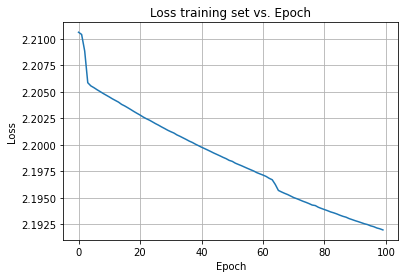

In [46]:
plt.plot(history.history["loss"])
plt.title("Loss training set vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

In [52]:
#Haz la predicción
model_encoder = keras.Model(inputs, encoder, name="encoder")
model_encoder.summary()

X_encoded=model_encoder(X_train_np).numpy()
print()
print(X_encoded.shape)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 300)]             0         
                                                                 
 encoder_layer_1 (Dense)     (None, 150)               45150     
                                                                 
 encoder_layer_2 (Dense)     (None, 88)                13288     
                                                                 
Total params: 58,438
Trainable params: 58,438
Non-trainable params: 0
_________________________________________________________________

(562, 88)
